# MICs | fastSurfer vs freeSurfer6??

In [3]:
subjects=['HC001' 'HC010' 'HC012' 'HC033' 'HC062' 'HC076' 'PX071']

## Replace the *fastSurfer* `mask.mgz`
Using the QCed mask from freesurfer and the *fastsurfer* `mask.mgz` and new file is generated and the surface mapping is obtained from here.

```bash
# From the micapipe_v0.2.0 directory
here=/data_/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0
cd $here

# Loop over the rest of the subjects to test
for s in HC012 HC033 HC062 HC076 PX071; do
	# set variables
	sub=sub-${s}
	ses=ses-01
	idBIDS=${sub}_${ses}
	threads=15
	SUBJECTS_DIR=/data_/mica3/BIDS_MICs/derivatives/fastsurfer
	fs_licence=/data_/mica1/01_programs/freesurfer-7.3.2/license.txt
	fastsurfer_img=/data_/mica1/01_programs/fastsurfer/fastsurfer-cpu-v2.0.0.sif
	T1nativepro=/data_/mica3/BIDS_MICs/derivatives/micapipe_v0.2.0/${sub}/${ses}/anat/${idBIDS}_space-nativepro_T1w.nii.gz
	freesurfer_dir=/data_/mica3/BIDS_MICs/derivatives/freesurfer
	
	# tmp directory
	tmp="/tmp/free2fast_${RANDOM}"
	mkdir -p ${tmp} && chmod 777 ${tmp}
	# note I changed the tmp dir bc --surf_only is failing to mktmp a directory on the localhost/yeatman ??? I DON'T KNOW WHY
	export TMPDIR="${tmp}"
	
	# Run fastsurfer segmentation only
	mkdir -p ${SUBJECTS_DIR}
	singularity exec --nv -B "${SUBJECTS_DIR}":/output -B "${T1nativepro}/":/anat/T1w.nii.gz -B "${fs_licence}:/license.txt" \
		"${fastsurfer_img}" /fastsurfer/run_fastsurfer.sh --fs_license /license.txt --t1 /anat/T1w.nii.gz --sid "${idBIDS}" --sd /output --no_fs_T1 --seg_only --parallel --threads "${threads}"
	
	# Replace the mask and norm from the QCed freesurfer6 on fastsurfer
	cd ${SUBJECTS_DIR}/${idBIDS}/mri
	orig_free=${tmp}/orig_freesurfer.nii.gz
	orig_fast=${tmp}/orig.nii.gz
	orig_str="${tmp}/from-freesurfer_to-fastsurfer_"
	orig_mat="${orig_str}0GenericAffine.mat"
	mask_free=${tmp}/brain_masked.nii.gz
	mask_fast=${tmp}/mask.nii.gz
	mask_U=${tmp}/union_mask.nii.gz
	
	mrconvert orig.mgz ${orig_fast}
	mrconvert mask.mgz ${mask_fast}
	mrconvert ${freesurfer_dir}/${idBIDS}/mri/brainmask.mgz ${tmp}/brainmask.nii.gz
	mrconvert ${freesurfer_dir}/${idBIDS}/mri/orig.mgz ${orig_free}
	
	# Remove freesurfer off-set
	antsRegistrationSyN.sh -d 3 -m "${orig_free}" -f "${orig_fast}"  -o "${orig_str}" -t a -n "$threads" -p d
	antsApplyTransforms -d 3 -i "${tmp}/brainmask.nii.gz" -r "${orig_fast}" -t "$orig_mat" -o "$mask_free" -v -u int
	
	# Get the union mask
	fslmaths ${mask_free} -bin -mul ${mask_fast} ${mask_U}
	
	# Replace the fastsurfer mask with the union_mask
	rm mask.mgz
	mrconvert ${mask_U} mask.mgz
	
	# Run the laplaician eigen mapping to generate the new surfaces
	singularity exec --nv -B "${SUBJECTS_DIR}":/output -B "${T1nativepro}/":/anat/T1w.nii.gz -B "${fs_licence}:/license.txt" \
		"${fastsurfer_img}" /fastsurfer/run_fastsurfer.sh --fs_license /license.txt --t1 /anat/T1w.nii.gz --sid "${idBIDS}" --sd /output --no_fs_T1 --surf_only --parallel --threads "${threads}"
	
	# Remove tmp dir
	rm -rfv ${tmp}
	cd $here
done
```

In [8]:
# Set the environment
import os
import numpy as np
import matplotlib as plt
import nibabel as nb
from nibabel.freesurfer.mghformat import load
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.mesh.array_operations import smooth_array
import seaborn as sns
import matplotlib.pyplot as mpl
import seaborn as sns


# Set the working directory to the 'out' directory
os.chdir("/data_/mica3/BIDS_MICs") 

outDir='/data_/mica3/BIDS_MICs/derivatives/'
out=outDir + 'micapipe_v0.2.0/'
sub='sub-HC001'
subjectID=sub+'_ses-01'
subjectDir=out + sub+'/ses-01'

# Set paths and variables
dir_free = outDir + 'freesurfer/' + subjectID
dir_fast = outDir + 'fastsurfer/' + subjectID

# Load freesurfer pial surface
surf_lh = read_surface(dir_free+'/surf/lh.pial', itype='fs')
surf_rh = read_surface(dir_free+'/surf/rh.pial', itype='fs')

# Load freesurfer white matter surface
wm_lh = read_surface(dir_free+'/surf/lh.white', itype='fs')
wm_rh = read_surface(dir_free+'/surf/rh.white', itype='fs')

# Load freesurfer inflated surface
inf_lh = read_surface(dir_free+'/surf/lh.inflated', itype='fs')
inf_rh = read_surface(dir_free+'/surf/rh.inflated', itype='fs')

# Colormap
ColCurv= plt.colors.ListedColormap(['#A2CD5A', '#A0CA5B', '#9FC85C', '#9EC55D', '#9DC35E', '#9CC05F', '#9BBE61', '#9ABB62', '#99B963', '#98B664', '#96B465', '#95B166', '#94AF68', '#93AC69', '#92AA6A', '#91A76B', '#90A56C', '#8FA26D', '#8EA06F', '#8C9D70', '#8B9B71', '#8A9972', '#899673', '#889475', '#879176', '#868F77', '#858C78', '#848A79', '#82877A', '#81857C', '#80827D', '#7F807E', '#807D7D', '#827A7A', '#857777', '#877575', '#8A7272', '#8C6F6F', '#8F6C6C', '#916969', '#946666', '#966464', '#996161', '#9B5E5E', '#9D5B5B', '#A05858', '#A25656', '#A55353', '#A75050', '#AA4D4D', '#AC4A4A', '#AF4747', '#B14545', '#B44242', '#B63F3F', '#B93C3C', '#BB3939', '#BE3636', '#C03434', '#C33131', '#C52E2E', '#C82B2B', '#CA2828', '#CD2626'])
grey = plt.colors.ListedColormap(np.full((256, 4), [0.65, 0.65, 0.65, 1]))


In [9]:
# Load native pial surface
surf_lhr = read_surface(dir_fast+'/surf/lh.pial', itype='fs')
surf_rhr = read_surface(dir_fast+'/surf/rh.pial', itype='fs')

# Load native inflated surface
inf_lhr = read_surface(dir_fast+'/surf/lh.inflated', itype='fs')
inf_rhr = read_surface(dir_fast+'/surf/rh.inflated', itype='fs')

# Load native white matter surface
wm_lhr = read_surface(dir_fast+'/surf/lh.white', itype='fs')
wm_rhr = read_surface(dir_fast+'/surf/rh.white', itype='fs')

2023-04-21 12:06:04.661 ( 325.439s) [        A9854200] vtkPythonAlgorithm.cxx:112    ERR| vtkPythonAlgorithm (0x3b86d70): Failure when calling method: "ProcessRequest":


FileNotFoundError: [Errno 2] No such file or directory: '/data_/mica3/BIDS_MICs/derivatives/fastsurfer/sub-HC001_ses-01/surf/lh.pial'

2023-04-21 12:06:04.771 ( 325.549s) [        A9854200]       vtkExecutive.cxx:740    ERR| vtkCompositeDataPipeline (0xdd87b30): Algorithm vtkPythonAlgorithm (0x3b86d70) returned failure for request: vtkInformation (0x3b58cd0)
  Debug: Off
  Modified Time: 20253
  Reference Count: 2
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: 0
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2023-04-21 12:06:04.774 ( 325.552s) [        A9854200] vtkPythonAlgorithm.cxx:112    ERR| vtkPythonAlgorithm (0x3b38bb0): Failure when calling method: "ProcessRequest":


FileNotFoundError: [Errno 2] No such file or directory: '/data_/mica3/BIDS_MICs/derivatives/fastsurfer/sub-HC001_ses-01/surf/rh.pial'

2023-04-21 12:06:04.779 ( 325.557s) [        A9854200]       vtkExecutive.cxx:740    ERR| vtkCompositeDataPipeline (0xdd87a40): Algorithm vtkPythonAlgorithm (0x3b38bb0) returned failure for request: vtkInformation (0x3ca62a0)
  Debug: Off
  Modified Time: 20397
  Reference Count: 2
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: 0
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2023-04-21 12:06:04.781 ( 325.559s) [        A9854200] vtkPythonAlgorithm.cxx:112    ERR| vtkPythonAlgorithm (0x3b86d70): Failure when calling method: "ProcessRequest":


FileNotFoundError: [Errno 2] No such file or directory: '/data_/mica3/BIDS_MICs/derivatives/fastsurfer/sub-HC001_ses-01/surf/lh.inflated'

2023-04-21 12:06:04.786 ( 325.565s) [        A9854200]       vtkExecutive.cxx:740    ERR| vtkCompositeDataPipeline (0xdd87b30): Algorithm vtkPythonAlgorithm (0x3b86d70) returned failure for request: vtkInformation (0x3b58cd0)
  Debug: Off
  Modified Time: 20544
  Reference Count: 2
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: 0
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2023-04-21 12:06:04.789 ( 325.567s) [        A9854200] vtkPythonAlgorithm.cxx:112    ERR| vtkPythonAlgorithm (0x3b38bb0): Failure when calling method: "ProcessRequest":


FileNotFoundError: [Errno 2] No such file or directory: '/data_/mica3/BIDS_MICs/derivatives/fastsurfer/sub-HC001_ses-01/surf/rh.inflated'

2023-04-21 12:06:04.795 ( 325.573s) [        A9854200]       vtkExecutive.cxx:740    ERR| vtkCompositeDataPipeline (0xdd87a40): Algorithm vtkPythonAlgorithm (0x3b38bb0) returned failure for request: vtkInformation (0x4be5310)
  Debug: Off
  Modified Time: 20701
  Reference Count: 2
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: 0
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2023-04-21 12:06:04.798 ( 325.576s) [        A9854200] vtkPythonAlgorithm.cxx:112    ERR| vtkPythonAlgorithm (0x3b86d70): Failure when calling method: "ProcessRequest":


FileNotFoundError: [Errno 2] No such file or directory: '/data_/mica3/BIDS_MICs/derivatives/fastsurfer/sub-HC001_ses-01/surf/lh.white'

2023-04-21 12:06:04.804 ( 325.582s) [        A9854200]       vtkExecutive.cxx:740    ERR| vtkCompositeDataPipeline (0xdd87b30): Algorithm vtkPythonAlgorithm (0x3b86d70) returned failure for request: vtkInformation (0xdd84360)
  Debug: Off
  Modified Time: 20858
  Reference Count: 2
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: 0
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2023-04-21 12:06:04.807 ( 325.585s) [        A9854200] vtkPythonAlgorithm.cxx:112    ERR| vtkPythonAlgorithm (0x3b38bb0): Failure when calling method: "ProcessRequest":


FileNotFoundError: [Errno 2] No such file or directory: '/data_/mica3/BIDS_MICs/derivatives/fastsurfer/sub-HC001_ses-01/surf/rh.white'

2023-04-21 12:06:04.813 ( 325.591s) [        A9854200]       vtkExecutive.cxx:740    ERR| vtkCompositeDataPipeline (0xdd87a40): Algorithm vtkPythonAlgorithm (0x3b38bb0) returned failure for request: vtkInformation (0x4542580)
  Debug: Off
  Modified Time: 21015
  Reference Count: 2
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: 0
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0




# Freesurfer: surface

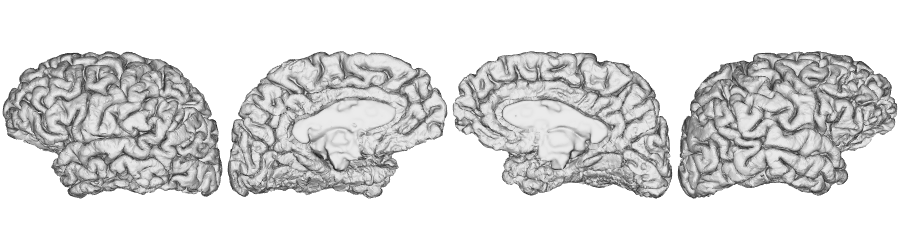

In [10]:
# Plot the surface
plot_hemispheres(surf_lh, surf_rh, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

# FastSurfer | surface

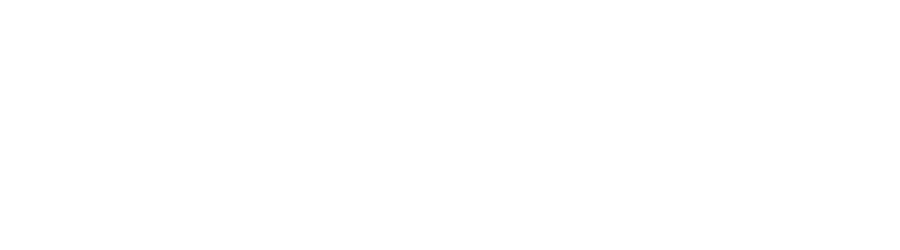

In [11]:
# Plot the surface
plot_hemispheres(surf_lhr, surf_rhr, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap=grey, transparent_bg=False)

# FreeSurfer | thickness

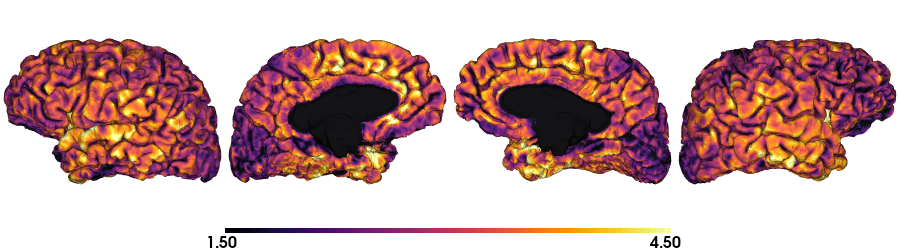

In [13]:
# Freesurfer native thickness
th = np.concatenate((nb.freesurfer.read_morph_data(dir_free + '/surf/lh.thickness'), nb.freesurfer.read_morph_data(dir_free + '/surf/rh.thickness')), axis=0)
plot_hemispheres(surf_lh, surf_rh, array_name=th, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(1.5, 4.5), cmap="inferno",transparent_bg=False)

# Fasturfer | thickness

In [14]:
# Fastsurfer native thickness
thr = np.concatenate((nb.freesurfer.read_morph_data(dir_fast + '/surf/lh.thickness'), nb.freesurfer.read_morph_data(dir_fast + '/surf/rh.thickness')), axis=0)
plot_hemispheres(surf_lhr, surf_rhr, array_name=thr, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(1.5, 4.5), cmap="inferno",transparent_bg=False)

FileNotFoundError: [Errno 2] No such file or directory: '/data_/mica3/BIDS_MICs/derivatives/fastsurfer/sub-HC001_ses-01/surf/lh.thickness'

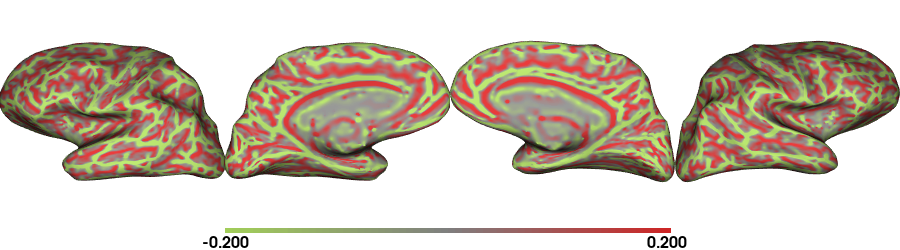

In [15]:
# Freesurfer native curvature
cv = np.concatenate((nb.freesurfer.read_morph_data(dir_free + '/surf/lh.curv'), nb.freesurfer.read_morph_data(dir_free + '/surf/rh.curv')), axis=0)
plot_hemispheres(inf_lh, inf_rh, array_name=cv, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap=ColCurv,transparent_bg=False)

In [ ]:
# Freesurfer native curvature
cv = np.concatenate((nb.freesurfer.read_morph_data(dir_fast + '/surf/lh.curv'), nb.freesurfer.read_morph_data(dir_fast + '/surf/rh.curv')), axis=0)
plot_hemispheres(wm_lhr, wm_rhr, array_name=cv, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap=ColCurv,transparent_bg=False)

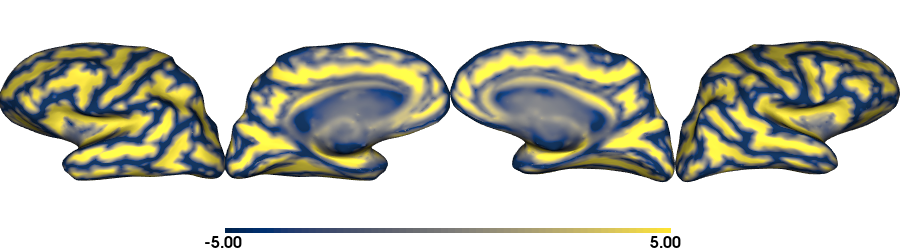

In [16]:
# Freesurfer native sulcal depth
sd = np.concatenate((nb.freesurfer.read_morph_data(dir_free + '/surf/lh.sulc'), nb.freesurfer.read_morph_data(dir_free + '/surf/rh.sulc')), axis=0)
plot_hemispheres(inf_lh, inf_rh, array_name=sd, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(-5, 5), cmap='cividis',transparent_bg=False)

In [ ]:
# Freesurfer native sulcal depth
sd = np.concatenate((nb.freesurfer.read_morph_data(dir_fast + '/surf/lh.sulc'), nb.freesurfer.read_morph_data(dir_fast + '/surf/rh.sulc')), axis=0)
plot_hemispheres(inf_lhr, inf_rhr, array_name=sd, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), color_range=(-5, 5), cmap='cividis',transparent_bg=False)

# Quantitative differences

## thickness

## curvature

## sulcal depth
